<div style="padding: 20px; border-radius: 10px; border: 2px solid #3A506B; background-color: #F1F6F9; color: #1C2541;">
    <h1 style="font-family: Arial, sans-serif; color: #3A506B; font-size: 2.5em; text-align: center; line-height: 1.2;">
        <span style="font-weight: bold;">Advanced topics in Deep Learning</span>
    </h1>
    <h2 style="font-family: Arial, sans-serif; color: #1C2541; text-align: center; font-size: 1.5em; font-weight: normal;">
        2024-2025
    </h2>
    <h2 style="font-family: Arial, sans-serif; color: #1C2541; text-align: center; font-size: 1.5em; font-weight: normal;">
        ----------------------------------
    </h2>
    <h2 style="font-family: Arial, sans-serif; color: #1C2541; text-align: center; font-size: 1.5em; font-weight: normal;">
        Final project
    </h2>
</div>

# Part 1 - EDA
### in this part we explore the data to understand more about the data distribution while trying to gain additional information that could be useful to us with our task. in addition to that we make our intial changes that we see would help the train process

In [3]:

# Import libraries for data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import defaultdict, Counter
import html
import re
import emoji
from textblob import TextBlob
from transformers import BertTokenizerFast
from urllib.parse import urlparse


# Setup for inline plotting and better visuals
%matplotlib inline
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)  # Show all columns when displaying a DataFrame


### Loading the data

In [4]:
# Load the training and test datasets
train = pd.read_csv("Corona_NLP_train.csv", encoding='ISO-8859-1')
test = pd.read_csv("Corona_NLP_test.csv", encoding='ISO-8859-1')


# Print the shape (rows, columns) of each dataset
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Display the first few rows of the training set
train.head()


Train shape: (41157, 6)
Test shape: (3798, 6)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
# Show column data types, non-null counts, and memory usage
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


After showing the data info, we can see that we dont have a probelm witrh null values except for the Location column

# ---------------------------------------------------------------------------------------

In [ ]:
### changing tweets for lowercases for better generalization

In [6]:

df['OriginalTweet']=df['OriginalTweet'].astype(str)
df['Sentiment']=df['Sentiment'].astype(str)


#lowercasing the tweet for generalization
df['OriginalTweet'] = df['OriginalTweet'].str.lower()



In [7]:
# Check how many missing values are in each column (if any)
missing = df.isnull().sum()
print(missing[missing > 0].sort_values(ascending=False))
# Count duplicated rows
print("Duplicate rows in train set:", train.duplicated().sum())


Location    8590
dtype: int64
Duplicate rows in train set: 0


In [8]:
# Value counts of target sentiment
print("🔢 Sentiment class distribution:")
print(train['Sentiment'].value_counts())

# Unique value counts per column
print("\n🔍 Number of unique values per column:")
print(train.nunique())

# Print one example tweet from each sentiment class
print("\n📝 Example tweet from each sentiment class:")
for sentiment in train['Sentiment'].unique():
    example = train[train['Sentiment'] == sentiment]['OriginalTweet'].iloc[0]
    print(f"\n➡ Sentiment: '{sentiment}'")
    print(example)


🔢 Sentiment class distribution:
Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

🔍 Number of unique values per column:
UserName         41157
ScreenName       41157
Location         12220
TweetAt             30
OriginalTweet    41155
Sentiment            5
dtype: int64

📝 Example tweet from each sentiment class:

➡ Sentiment: 'Neutral'
@menyrbie @phil_gahan @chrisitv https://t.co/ifz9fan2pa and https://t.co/xx6ghgfzcc and https://t.co/i2nlzdxno8

➡ Sentiment: 'Positive'
advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order

➡ Sentiment: 'Extremely Negative'
me, ready to go at supermarket during the #covid19 outbreak.

not because i'm paranoid, but because my food stock is littera

### droping useless columns

In [9]:
cols_to_drop = ['UserName','ScreenName']
train.drop(columns=cols_to_drop, inplace=True)
test.drop(columns=cols_to_drop, inplace=True)

train.head()

,Location,TweetAt,OriginalTweet,Sentiment
0,London,16-03-2020,@menyrbie @phil_gahan @chrisitv https://t.co/i...,Neutral
1,UK,16-03-2020,advice talk to your neighbours family to excha...,Positive
2,Vagabonds,16-03-2020,coronavirus australia: woolworths to give elde...,Positive
3,NaN,16-03-2020,my food stock is not the only one which is emp...,Positive
4,NaN,16-03-2020,"me, ready to go at supermarket during the #cov...",Extremely Negative


In [10]:
# Length of each tweet
train['char_count'] = train['OriginalTweet'].apply(len)
train['word_count'] = train['OriginalTweet'].apply(lambda x: len(x.split()))

print("\n✂️ Tweet length (characters):")
print(train['char_count'].describe())

print("\n✂️ Tweet length (words):")
print(train['word_count'].describe())


✂️ Tweet length (characters):
count    41157.000000
mean       204.200160
std         68.655129
min         11.000000
25%        151.000000
50%        215.000000
75%        259.000000
max        355.000000
Name: char_count, dtype: float64

✂️ Tweet length (words):
count    41157.000000
mean        30.500304
std         11.591172
min          1.000000
25%         21.000000
50%         32.000000
75%         40.000000
max         64.000000
Name: word_count, dtype: float64


In [ ]:
### here we try to see how well the labels are being distbuted

C:\Users\rabea\AppData\Local\Temp\ipykernel_21712\4213005975.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train, x='Sentiment', order=sentiment_order, palette=sentiment_palette)


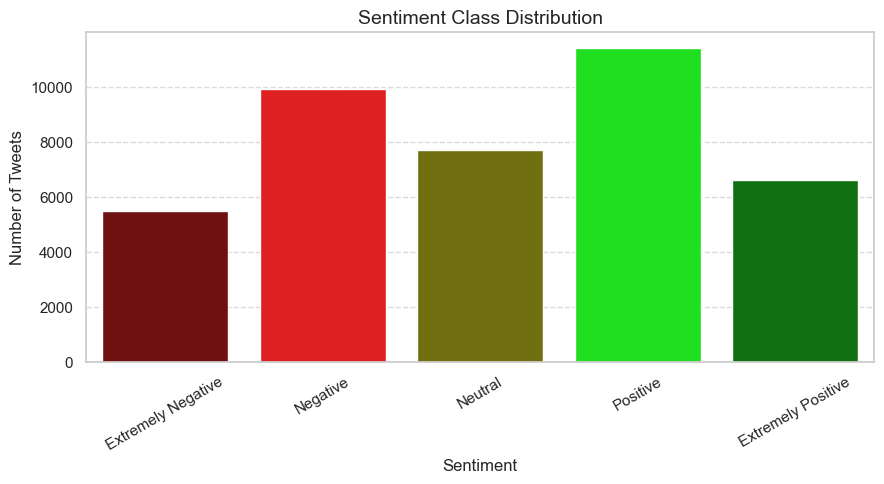

In [11]:

# setting the colors
sentiment_palette = {
    'Extremely Negative': '#800000',# dark red
    'Negative': '#ff0000',  # bright strong red
    'Neutral': '#808000',             # olive
    'Positive': '#00ff00',   # vibrant green
    'Extremely Positive': '#008000'# dark green
}


# Correct sentiment order
sentiment_order = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']

plt.figure(figsize=(9, 5))
sns.countplot(data=train, x='Sentiment', order=sentiment_order, palette=sentiment_palette)
plt.title("Sentiment Class Distribution", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



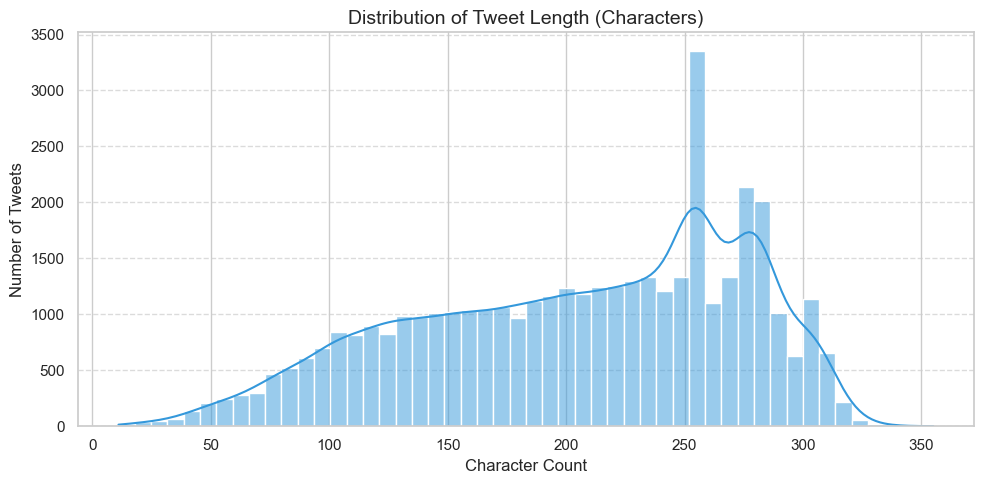

In [12]:
# Add character count column (if not already added)
train['char_count'] = train['OriginalTweet'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(data=train, x='char_count', bins=50, kde=True, color="#3498db")
plt.title("Distribution of Tweet Length (Characters)", fontsize=14)
plt.xlabel("Character Count")
plt.ylabel("Number of Tweets")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

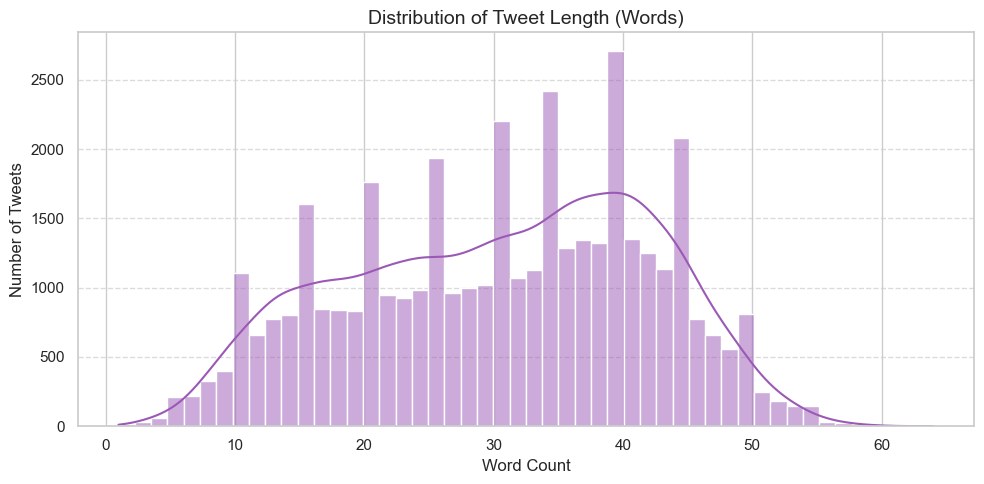

In [13]:
# Add word count column
train['word_count'] = train['OriginalTweet'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
sns.histplot(data=train, x='word_count', bins=50, kde=True, color="#9b59b6")
plt.title("Distribution of Tweet Length (Words)", fontsize=14)
plt.xlabel("Word Count")
plt.ylabel("Number of Tweets")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


C:\Users\rabea\AppData\Local\Temp\ipykernel_21712\1072987796.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train, x='Sentiment', y='word_count',


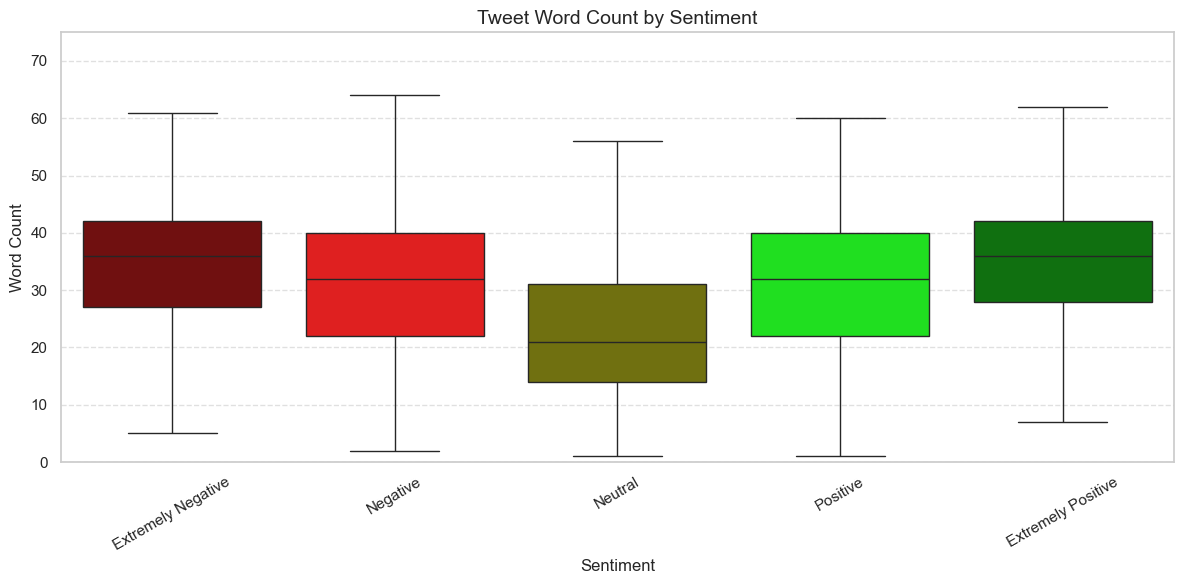

In [14]:
# Ensure word_count exists
if 'word_count' not in train.columns:
    train['word_count'] = train['OriginalTweet'].apply(lambda x: len(x.split()))

# Order and color palette
sentiment_order = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']

# Plot
plt.figure(figsize=(12, 6))

# Just the boxplot
sns.boxplot(data=train, x='Sentiment', y='word_count',
            order=sentiment_order, palette=sentiment_palette, showfliers=False)

plt.title("Tweet Word Count by Sentiment", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Word Count")
plt.ylim(0, 75)  # Zoom in
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



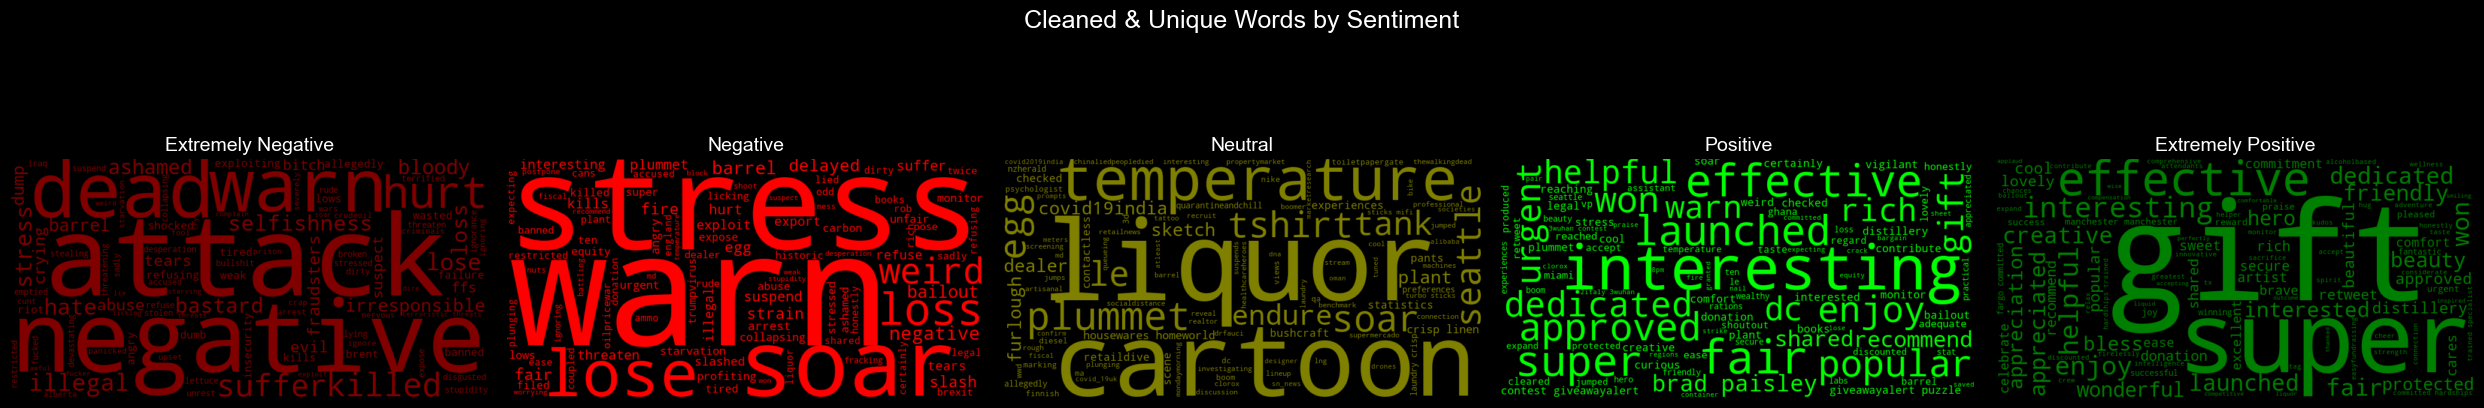

In [15]:
# Step 1: Clean tweets
# -----------------------------------
# Remove URLs
train['clean_text'] = train['OriginalTweet'].str.replace(r'http\S+', '', regex=True).str.strip()

# Decode HTML entities (e.g., &amp → &)
train['clean_text'] = train['clean_text'].apply(html.unescape)

# Remove non-ASCII characters (encoding noise like â, ®, etc.)
train['clean_text'] = train['clean_text'].str.encode('ascii', errors='ignore').str.decode('utf-8')

# Step 2: Normalize + tokenize for unique word filtering
# -----------------------------------
def tokenize(text):
    # Lowercase, remove punctuation, split to words
    return re.sub(r'[^\w\s]', '', text.lower()).split()

# Create a dictionary: {sentiment: set of words}
sentiment_words = defaultdict(set)

for sentiment in train['Sentiment'].unique():
    all_words = set()
    text = " ".join(train[train['Sentiment'] == sentiment]['clean_text'].astype(str))
    for word in tokenize(text):
        all_words.add(word)
    sentiment_words[sentiment] = all_words

# Step 3: Filter out shared words (appear in ≥ 2 sentiments)
# -----------------------------------
word_sentiment_count = Counter()

for sentiment, word_set in sentiment_words.items():
    for word in word_set:
        word_sentiment_count[word] += 1

# Only keep words that do NOT appear in all 5 sentiments
unique_words = {word for word, count in word_sentiment_count.items() if count < len(sentiment_words)}


# Step 4: Generate and plot all 5 WordClouds
# -----------------------------------
sentiment_order = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']

fig, axes = plt.subplots(1, 5, figsize=(25, 5), facecolor='black')

for i, sentiment in enumerate(sentiment_order):
    # Collect all unique words for this sentiment
    words = []
    for tweet in train[train['Sentiment'] == sentiment]['clean_text']:
        for word in tokenize(tweet):
            if word in unique_words:
                words.append(word)
    text = " ".join(words)

    # Generate WordCloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='black',
        color_func=lambda *args, **kwargs: sentiment_palette[sentiment],
        max_words=100,
        stopwords=None
    ).generate(text)

    # Plot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(sentiment, fontsize=14, color='white')

plt.suptitle("Cleaned & Unique Words by Sentiment", fontsize=18, color='white')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()



In [14]:
import country_converter as coco

# Clean text
train['CleanLocation'] = train['Location'].str.lower().str.strip()

# Try to convert to country names
train['InferredCountry'] = coco.convert(names=train['CleanLocation'], to='name_short')

# Optional: check failed matches
failed = train[train['InferredCountry'] == 'not found']


london not found in regex
nan not found in ISO3
nan not found in ISO3
ãt: 36.319708,-82.363649 not found in regex
35.926541,-78.753267 not found in regex
atlanta, ga usa not found in regex
bhavnagar,gujrat not found in regex
makati, manila not found in regex
horningsea not found in regex
chicago, il not found in regex
nan not found in ISO3
houston, texas not found in regex
north america not found in regex
denver, co not found in regex
southampton soxx xxx not found in regex
global not found in regex
nan not found in ISO3
nan not found in ISO3
downstage centre not found in regex
london not found in regex
ketchum, idaho not found in regex
everywhere you are! not found in regex
new york, ny not found in regex
someplace, usa not found in regex
nan not found in ISO3
nan not found in ISO3
markham, ontario not found in regex
sverige not found in regex
where the wild things are not found in regex
nan not found in ISO3
fort worth, texas not found in regex
nan not found in ISO3
houston not foun

KeyboardInterrupt: 

🔹 Extracting hashtags, mentions, and URLs...

✅ Sample counts:


,OriginalTweet,HashtagCount,MentionCount,URLCount
0,@menyrbie @phil_gahan @chrisitv https://t.co/i...,0,3,3
1,advice talk to your neighbours family to excha...,0,0,0
2,coronavirus australia: woolworths to give elde...,0,0,1
3,my food stock is not the only one which is emp...,7,0,1
4,"me, ready to go at supermarket during the #cov...",6,0,1



📊 Distribution of Hashtag Count:


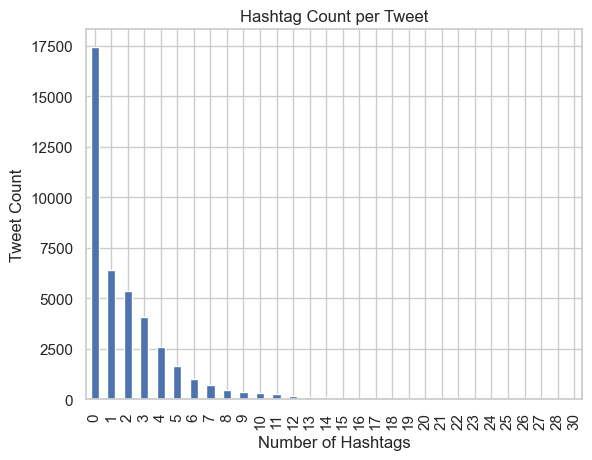


📊 Distribution of Mention Count:


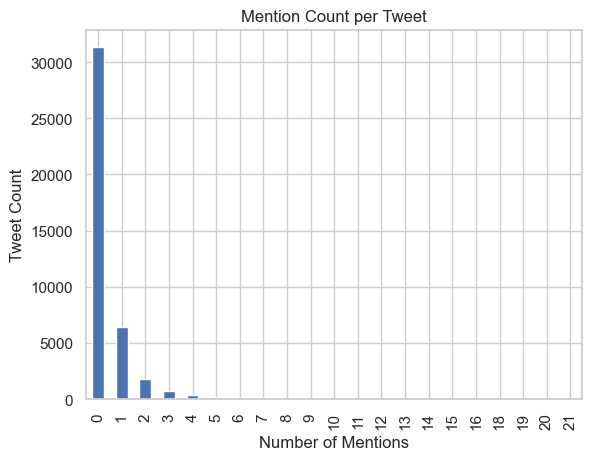


📊 Distribution of URL Count:


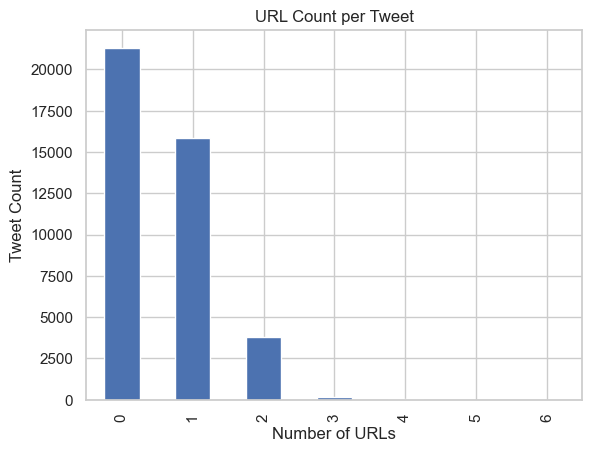

In [16]:

# Show all columns in output
pd.set_option('display.max_columns', None)

# Step 2: Extract Hashtags, Mentions, URLs
print("🔹 Extracting hashtags, mentions, and URLs...")

df['HashtagCount'] = df['OriginalTweet'].str.count(r'#\w+')
df['MentionCount'] = df['OriginalTweet'].str.count(r'@\w+')
df['URLCount'] = df['OriginalTweet'].str.count(r'http\S+')

print("\n✅ Sample counts:")
display(train[['OriginalTweet', 'HashtagCount', 'MentionCount', 'URLCount']].head(5))

# Distribution plots
print("\n📊 Distribution of Hashtag Count:")
df['HashtagCount'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Number of Hashtags")
plt.ylabel("Tweet Count")
plt.title("Hashtag Count per Tweet")
plt.show()

print("\n📊 Distribution of Mention Count:")
df['MentionCount'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Number of Mentions")
plt.ylabel("Tweet Count")
plt.title("Mention Count per Tweet")
plt.show()

print("\n📊 Distribution of URL Count:")
df['URLCount'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Number of URLs")
plt.ylabel("Tweet Count")
plt.title("URL Count per Tweet")
plt.show()


In [17]:
print("🔹 10 tweets with NO hashtags:\n")

no_hashtag_tweets = df[df['HashtagCount'] == 0].copy()

for i, tweet in enumerate(no_hashtag_tweets['OriginalTweet'].head(10), 1):
    print(f"{i}. {tweet}\n")


🔹 10 tweets with NO hashtags:

1. @menyrbie @phil_gahan @chrisitv https://t.co/ifz9fan2pa and https://t.co/xx6ghgfzcc and https://t.co/i2nlzdxno8

2. advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order

3. coronavirus australia: woolworths to give elderly, disabled dedicated shopping hours amid covid-19 outbreak https://t.co/binca9vp8p

4. as news of the regionâs first confirmed covid-19 case came out of sullivan county last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @tim_dodson reports https://t.co/cfxch7a2lu

5. due to covid-19 our retail store and classroom in atlanta will not be open for walk-in business or classes for the next two weeks, beginning monday, march 16.  we will continue to process online and phone orders as no

we notice that the 8th row still has a "#" but its a weird tweet that doesnt mean anything, its probably due to data corruption, so we take care of data like that.

✅ Mean question marks per tweet: 0.57
✅ Standard deviation: 4.07


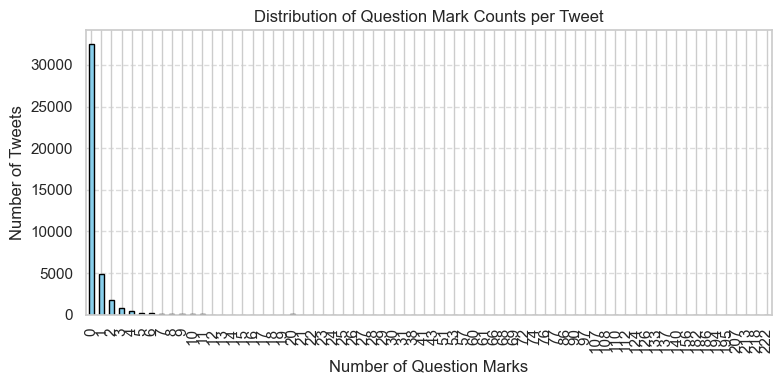

In [18]:

# Step 1: Count question marks
df['QuestionMarkCount'] = df['OriginalTweet'].str.count(r'\?')

# Step 2: Calculate stats
mean_q = df['QuestionMarkCount'].mean()
std_q = df['QuestionMarkCount'].std()

print(f"✅ Mean question marks per tweet: {mean_q:.2f}")
print(f"✅ Standard deviation: {std_q:.2f}")

# Step 3: Plot distribution
plt.figure(figsize=(8, 4))
df['QuestionMarkCount'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution of Question Mark Counts per Tweet")
plt.xlabel("Number of Question Marks")
plt.ylabel("Number of Tweets")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [19]:
max_q = df['QuestionMarkCount'].max()
print(f"🚨 Maximum number of question marks in a single tweet: {max_q}")


🚨 Maximum number of question marks in a single tweet: 222


showing the distribution of more than 0 question marks for a better visual:

✅ Mean question marks per tweet : 0.57
✅ Standard deviation : 4.07


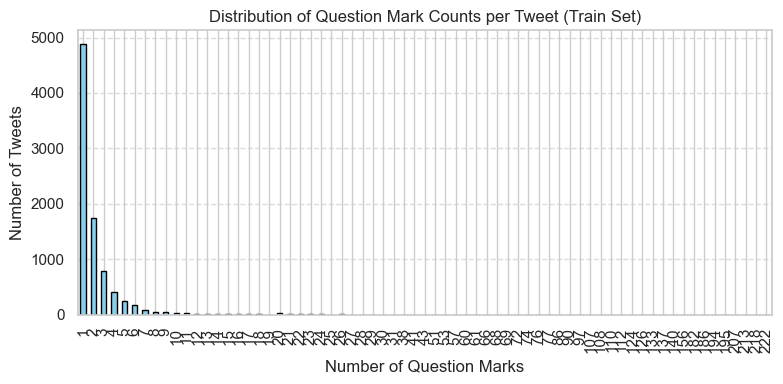

In [20]:
import matplotlib.pyplot as plt

# Step 1: Count question marks
df['QuestionMarkCount'] = df['OriginalTweet'].str.count(r'\?')

# Step 2: Calculate stats
mean_q = train['QuestionMarkCount'].mean()
std_q = train['QuestionMarkCount'].std()

print(f"✅ Mean question marks per tweet : {mean_q:.2f}")
print(f"✅ Standard deviation : {std_q:.2f}")

# Step 3: Plot distribution (only tweets with >0 question marks)
plt.figure(figsize=(8, 4))
df[df['QuestionMarkCount'] > 0]['QuestionMarkCount'] \
    .value_counts() \
    .sort_index() \
    .plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Distribution of Question Mark Counts per Tweet (Train Set)")
plt.xlabel("Number of Question Marks")
plt.ylabel("Number of Tweets")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



we have decided to drop tweets where there are question marks more than normal charchters

In [21]:
# Count question marks
df['QuestionMarkCount'] = df['OriginalTweet'].str.count(r'\?')

# Count alphabetic letters only (A-Z and a-z)
df['LetterCount'] = df['OriginalTweet'].str.count(r'[A-Za-z]')

# Drop tweets where ? > letters
num_dropped = (df['QuestionMarkCount'] > df['LetterCount']).sum()
print(f"🚮 Tweets dropped (more ? than letters): {num_dropped}")

df = df[df['QuestionMarkCount'] <= df['LetterCount']].copy()


🚮 Tweets dropped (more ? than letters): 30


now we look at mentions

✅ Mean mentions per tweet: 0.43
✅ Standard deviation: 1.13


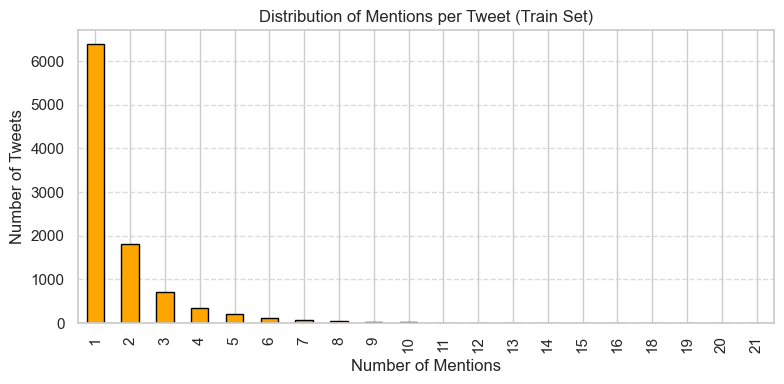

🏆 Top 10 most mentioned usernames:
@realdonaldtrump: 254
@tesco: 199
@sainsburys: 161
@borisjohnson: 151
@amazon: 128
@narendramodi: 110
@asda: 109
@pmoindia: 96
@morrisons: 92
@piersmorgan: 85


In [22]:
df['MentionCount'] = df['OriginalTweet'].str.count(r'@\w+')

mean_m = df['MentionCount'].mean()
std_m = df['MentionCount'].std()

print(f"✅ Mean mentions per tweet: {mean_m:.2f}")
print(f"✅ Standard deviation: {std_m:.2f}")

# Distribution plot (only where mentions > 0)
plt.figure(figsize=(8, 4))
train[train['MentionCount'] > 0]['MentionCount'] \
    .value_counts() \
    .sort_index() \
    .plot(kind='bar', color='orange', edgecolor='black')

plt.title("Distribution of Mentions per Tweet (Train Set)")
plt.xlabel("Number of Mentions")
plt.ylabel("Number of Tweets")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

def extract_mentions(text):
    return re.findall(r'@\w+', text)

# Flatten list of all mentions in all tweets
all_mentions = train['OriginalTweet'].apply(extract_mentions).explode()
top_mentions = Counter(all_mentions.dropna()).most_common(10)

print("🏆 Top 10 most mentioned usernames:")
for mention, count in top_mentions:
    print(f"{mention}: {count}")



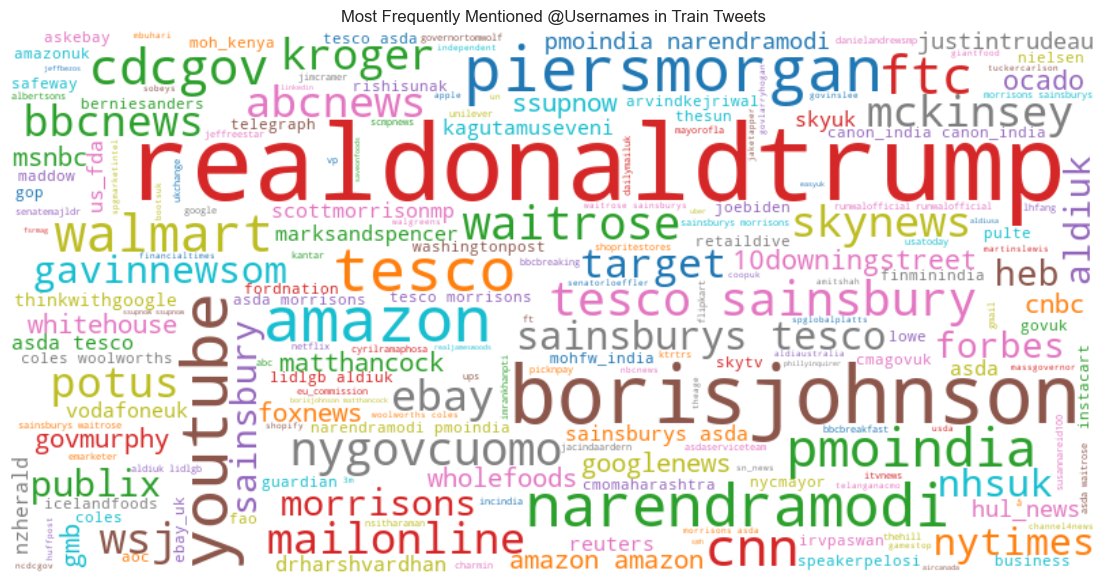

In [23]:

def extract_mentions(text):
    return re.findall(r'@\w+', text)

train['MentionsList'] = train['OriginalTweet'].apply(extract_mentions)
from itertools import chain

all_mentions = list(chain.from_iterable(train['MentionsList']))


# Join all mentions into one string (space-separated)
mention_text = " ".join(all_mentions)

# Generate word cloud
wc = WordCloud(width=800, height=400, background_color='white', colormap='tab10').generate(mention_text)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequently Mentioned @Usernames in Train Tweets")
plt.tight_layout()
plt.show()


checking sentiments for top 5 mentioned accounts

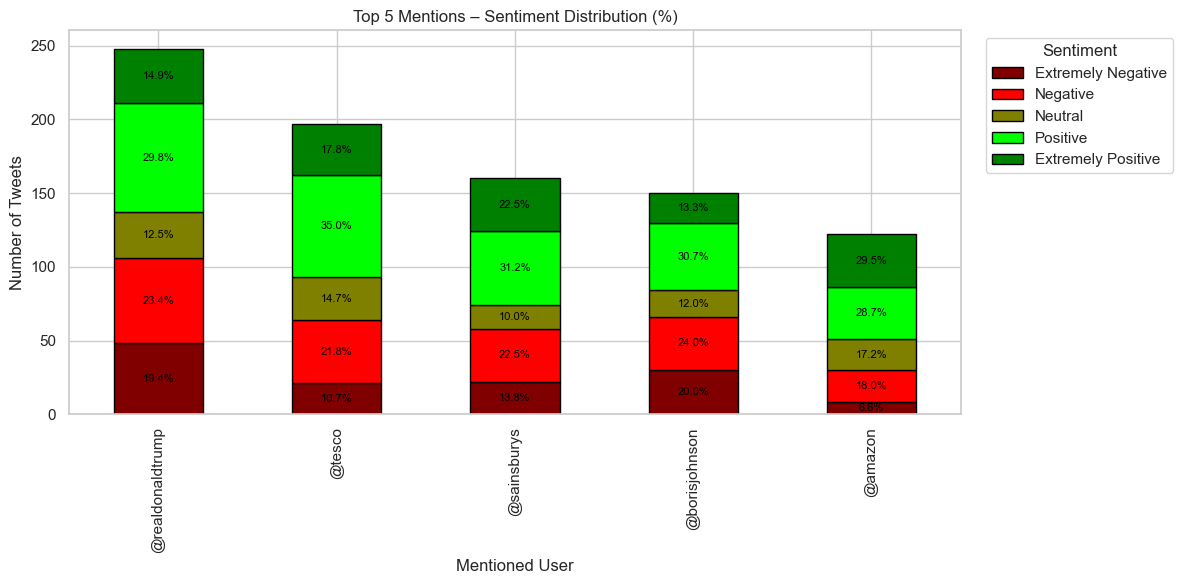

In [24]:

# Step 1: Extract mentions
train['MentionsList'] = train['OriginalTweet'].apply(lambda x: re.findall(r'@\w+', x))

# Step 2: Get top 5 mentions
all_mentions = train['MentionsList'].explode()
top_mentions = all_mentions.value_counts().head(5).index.tolist()

# Step 3: Create mention flags
for mention in top_mentions:
    train[f'has_{mention}'] = train['MentionsList'].apply(lambda x: mention in x)

# Step 4: Count sentiment distribution for each mention
sentiment_mention_counts = pd.DataFrame()

for mention in top_mentions:
    counts = train[train[f'has_{mention}']].groupby('Sentiment').size()
    sentiment_mention_counts[mention] = counts

sentiment_mention_counts = sentiment_mention_counts.fillna(0).astype(int)
sentiment_mention_counts = sentiment_mention_counts.reindex([
    'Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'
])  # ensure sentiment order

# Step 5: Plotting with custom palette
sentiment_palette = {
    'Extremely Negative': '#800000',
    'Negative': '#ff0000',
    'Neutral': '#808000',
    'Positive': '#00ff00',
    'Extremely Positive': '#008000'
}

ax = sentiment_mention_counts.T.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=[sentiment_palette[s] for s in sentiment_mention_counts.index],
    edgecolor='black'
)

plt.title("Top 5 Mentions – Sentiment Distribution (%)")
plt.xlabel("Mentioned User")
plt.ylabel("Number of Tweets")
plt.legend(title="Sentiment", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()

# Step 6: Annotate with percentages
for bar_idx, user in enumerate(sentiment_mention_counts.columns):
    total = sentiment_mention_counts[user].sum()
    bottom = 0
    for sentiment in sentiment_mention_counts.index:
        value = sentiment_mention_counts.loc[sentiment, user]
        if value > 0:
            pct = (value / total) * 100
            ax.text(bar_idx, bottom + value / 2, f"{pct:.1f}%", ha='center', va='center', fontsize=8, color='black')
            bottom += value

plt.show()


C:\Users\rabea\AppData\Local\Temp\ipykernel_21712\2766361405.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


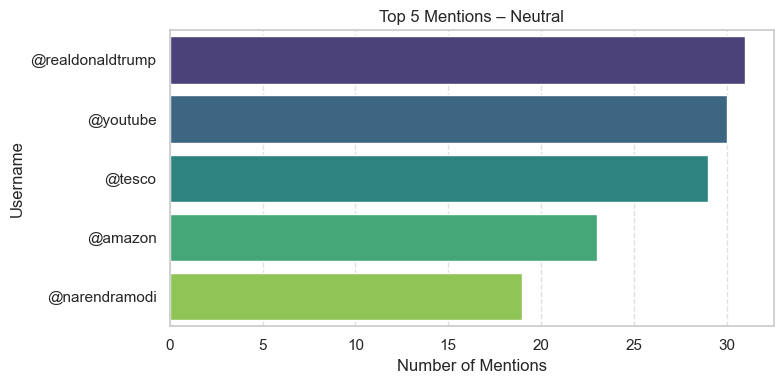

C:\Users\rabea\AppData\Local\Temp\ipykernel_21712\2766361405.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


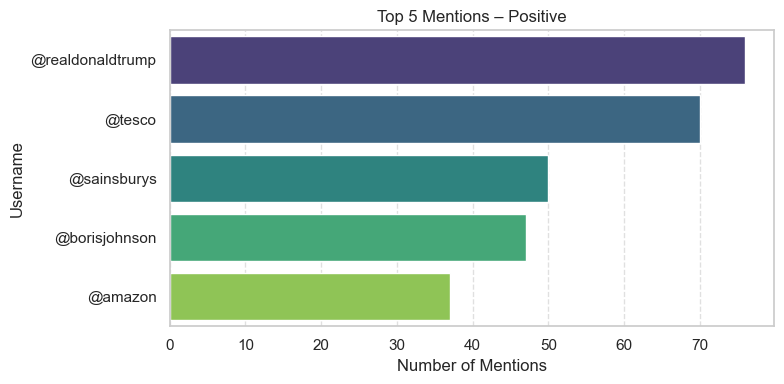

C:\Users\rabea\AppData\Local\Temp\ipykernel_21712\2766361405.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


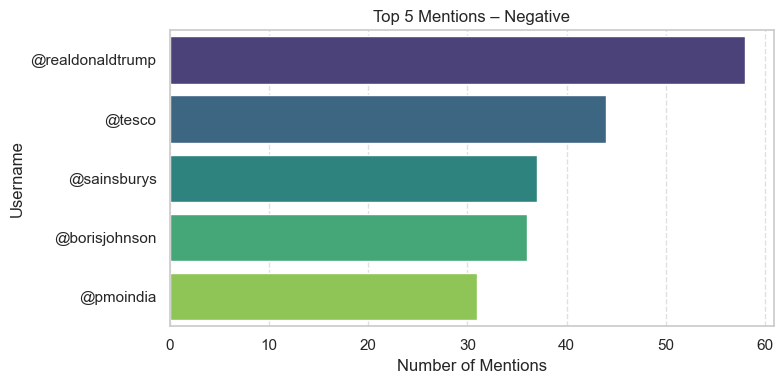

C:\Users\rabea\AppData\Local\Temp\ipykernel_21712\2766361405.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


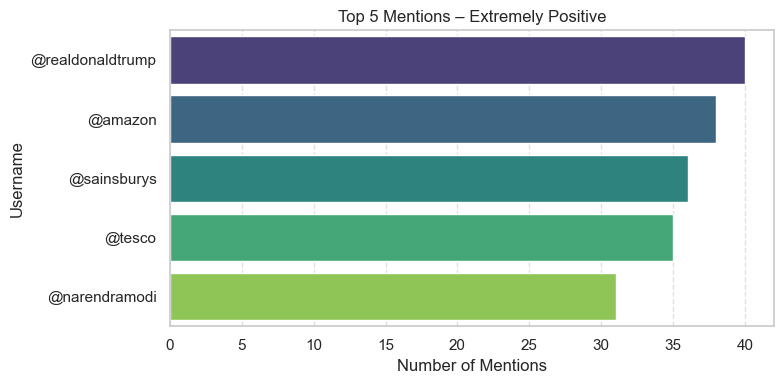

C:\Users\rabea\AppData\Local\Temp\ipykernel_21712\2766361405.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


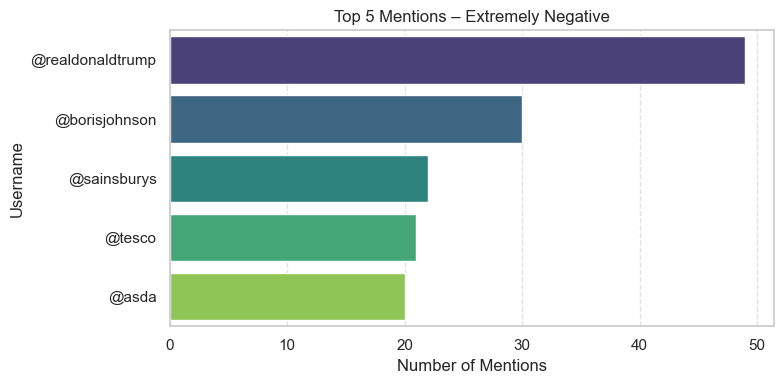

In [25]:

# Step 1: Extract mentions if not done
train['MentionsList'] = train['OriginalTweet'].apply(lambda x: re.findall(r'@\w+', x))

# Step 2: Explode mentions
exploded = train.explode('MentionsList')
exploded = exploded[exploded['MentionsList'].notna()]

# Step 3: Unique sentiment list
sentiments = exploded['Sentiment'].unique()

# Step 4: Plot per sentiment
for sentiment in sentiments:
    subset = exploded[exploded['Sentiment'] == sentiment]
    top_mentions = subset['MentionsList'].value_counts().head(5)

    # Create figure
    plt.figure(figsize=(8, 4))
    sns.barplot(
        x=top_mentions.values,
        y=top_mentions.index,
        palette='viridis'
    )

    plt.title(f"Top 5 Mentions – {sentiment}")
    plt.xlabel("Number of Mentions")
    plt.ylabel("Username")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


now we look at the urls

✅ Mean URLs per tweet: 0.58
✅ Standard deviation: 0.68


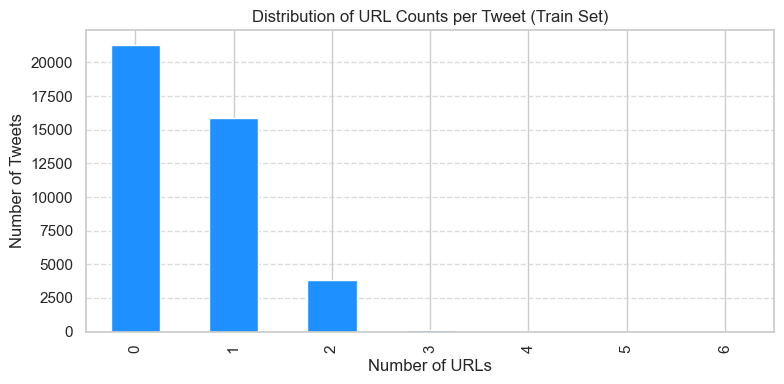

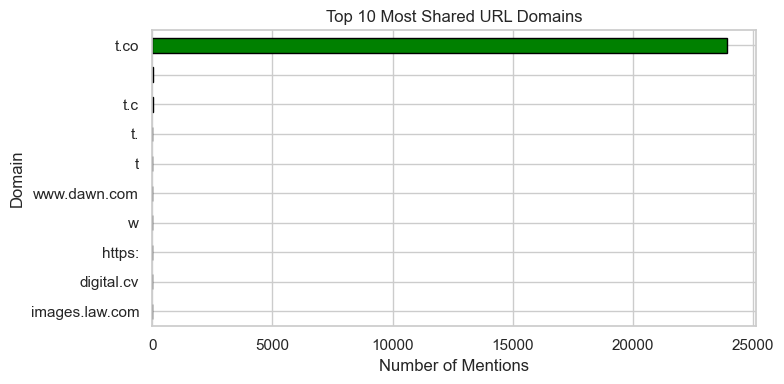

In [26]:

# Step 1: Count how many URLs in each tweet
train['URLCount'] = train['OriginalTweet'].str.count(r'http\S+')

# Step 2: Show basic stats
mean_url = train['URLCount'].mean()
std_url = train['URLCount'].std()

print(f"✅ Mean URLs per tweet: {mean_url:.2f}")
print(f"✅ Standard deviation: {std_url:.2f}")

# Step 3: Plot URL count distribution (> 0 only)
plt.figure(figsize=(8, 4))
train[train['URLCount'] >= 0]['URLCount'].value_counts().sort_index().plot(kind='bar', color='dodgerblue')
plt.title("Distribution of URL Counts per Tweet (Train Set)")
plt.xlabel("Number of URLs")
plt.ylabel("Number of Tweets")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 4: Extract list of URLs per tweet
train['URLList'] = train['OriginalTweet'].apply(lambda x: re.findall(r'http\S+', x))

# Flatten all URLs into one list
all_urls = train['URLList'].explode().dropna()

# Extract domain from each URL
domains = all_urls.apply(lambda url: urlparse(url).netloc.lower())
top_domains = domains.value_counts().head(10)

# Plot top domains
plt.figure(figsize=(8, 4))
top_domains.plot(kind='barh', color='green', edgecolor='black')
plt.title("Top 10 Most Shared URL Domains")
plt.xlabel("Number of Mentions")
plt.ylabel("Domain")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [27]:

# Extract list of URLs from tweet
train['URLList'] = train['OriginalTweet'].apply(lambda x: re.findall(r'http\S+', x))

# Explode to get one URL per row
urls = train.explode('URLList')
urls = urls[urls['URLList'].notna()].copy()

# Extract domain
urls['URLDomain'] = urls['URLList'].apply(lambda u: urlparse(u).netloc.lower())

# Show top 10 domains
print(urls['URLDomain'].value_counts().head(10))


URLDomain
t.co              23942
                     20
t.c                   7
t.                    4
t                     3
www.dawn.com          1
w                     1
https:                1
digital.cv            1
images.law.com        1
Name: count, dtype: int64


as we can see that most urls are links to a tweet, this sometimes links us to internal Twitter links (e.g., retweets, quoted tweets, shortened tweet URLs) or a link to the actual tweet itself, we have tried to look for a use for these tweets in our project but found out that its not that useful hence that after a short manual look we found out that its just links to the tweet itself.



as a way to deal with urls, we have decided to change the urls into the word "URL" to not miss with the future tokenization

In [28]:

# Step 1: Replace URLs with the word "URL"
def replace_url(text):
    return re.sub(r"http\S+", "URL", text)

train['OriginalTweet'] = train['OriginalTweet'].apply(replace_url)
test['OriginalTweet'] = test['OriginalTweet'].apply(replace_url)
# Step 2: Show 5 tweets that originally had URLs (now replaced with "URL")
tweets_with_replaced_urls = train[train['OriginalTweet'].str.contains(r'\bURL\b', case=False)]
print("🧾 Sample tweets after URL replacement:\n")
for i, tweet in enumerate(tweets_with_replaced_urls['OriginalTweet'].head(5), 1):
    print(f"{i}. {tweet}\n")


🧾 Sample tweets after URL replacement:

1. @menyrbie @phil_gahan @chrisitv URL and URL and URL

2. coronavirus australia: woolworths to give elderly, disabled dedicated shopping hours amid covid-19 outbreak URL

3. my food stock is not the only one which is empty...

please, don't panic, there will be enough food for everyone if you do not take more than you need. 
stay calm, stay safe.

#covid19france #covid_19 #covid19 #coronavirus #confinement #confinementotal #confinementgeneral URL

4. me, ready to go at supermarket during the #covid19 outbreak.

not because i'm paranoid, but because my food stock is litteraly empty. the #coronavirus is a serious thing, but please, don't panic. it causes shortage...

#coronavirusfrance #restezchezvous #stayathome #confinement URL

5. as news of the regionâs first confirmed covid-19 case came out of sullivan county last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @tim_dodso

In [29]:
train['URLCount'] = train['OriginalTweet'].str.count(r'http\S+')


mean_url = train['URLCount'].mean()
std_url = train['URLCount'].std()

print(f"✅ Mean URLs per tweet: {mean_url:.2f}")
print(f"✅ Standard deviation: {std_url:.2f}")


✅ Mean URLs per tweet: 0.00
✅ Standard deviation: 0.00


now we will explore other columns:
we explored the dates that the tweets were published

C:\Users\rabea\AppData\Local\Temp\ipykernel_21712\3698701433.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  train['TweetAt'] = pd.to_datetime(train['TweetAt'], errors='coerce')


<Axes: title={'center': 'Tweet Frequency Over Time'}, xlabel='TweetDate'>

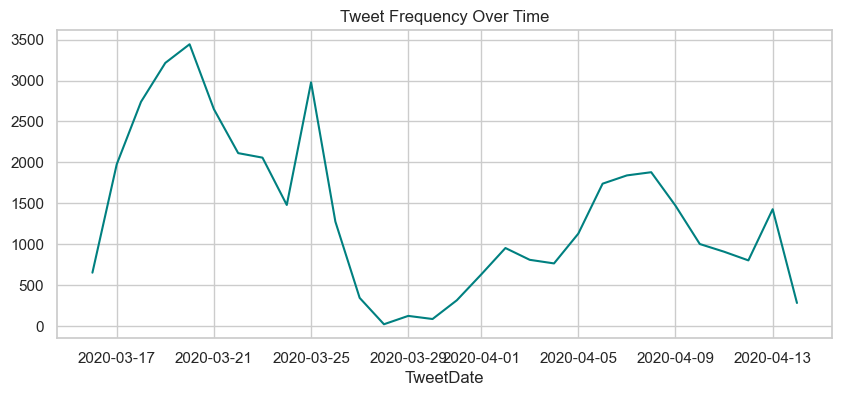

In [30]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], errors='coerce')
test['TweetAt'] = pd.to_datetime(test['TweetAt'], errors='coerce')

train['TweetDate'] = train['TweetAt'].dt.date
train['TweetDate'].value_counts().sort_index().plot(
    kind='line', figsize=(10, 4), title="Tweet Frequency Over Time", color='teal')


<Axes: title={'center': 'Tweet Volume by Weekday'}, xlabel='TweetWeekday'>

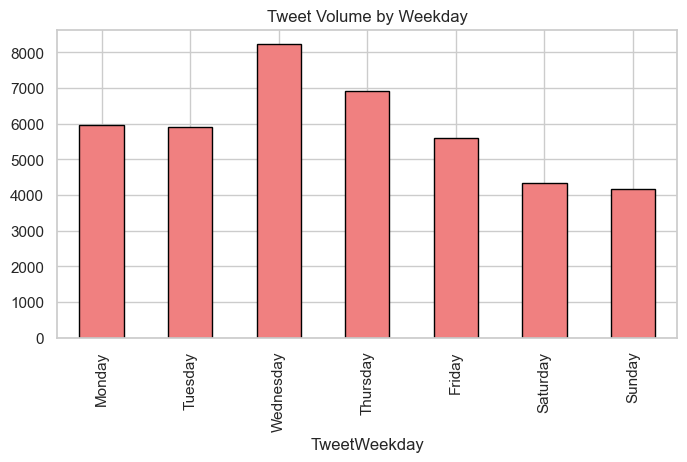

In [31]:
train['TweetWeekday'] = train['TweetAt'].dt.day_name()

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

train['TweetWeekday'].value_counts().reindex(weekday_order).plot(
    kind='bar', figsize=(8, 4), title='Tweet Volume by Weekday', color='lightcoral', edgecolor='black')


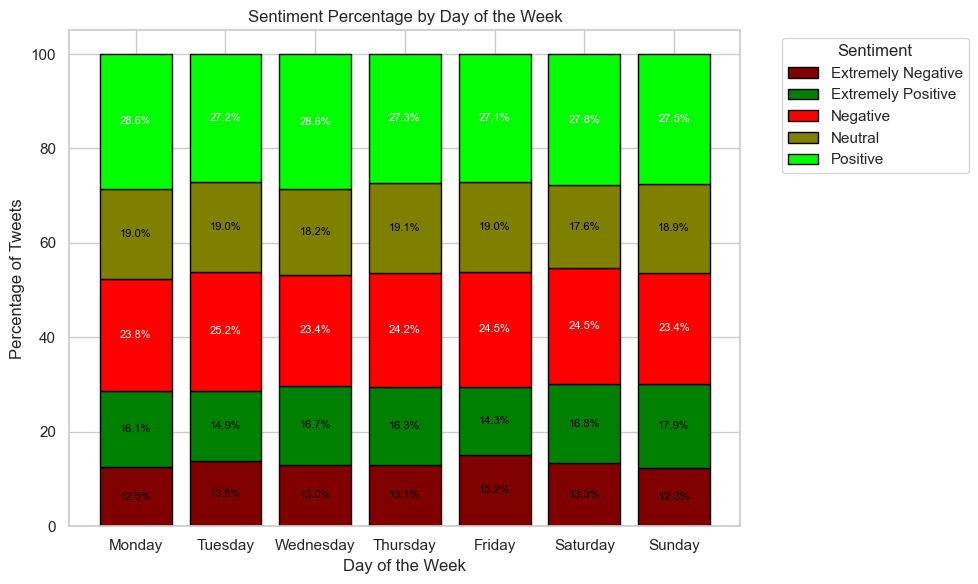

In [32]:

# Step 1: Extract weekday names
train['TweetWeekday'] = train['TweetAt'].dt.day_name()

# Step 2: Count tweets per sentiment per weekday
weekday_counts = train.groupby(['TweetWeekday', 'Sentiment']).size().unstack().fillna(0)

# Step 3: Convert to percentages
weekday_percent = weekday_counts.div(weekday_counts.sum(axis=1), axis=0) * 100

# Step 4: Reorder weekday index
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_percent = weekday_percent.reindex(weekday_order)

# Step 5: Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

colors = {
    'Extremely Negative': '#800000',
    'Negative': '#ff0000',
    'Neutral': '#808000',
    'Positive': '#00ff00',
    'Extremely Positive': '#008000'
}

bottom = [0] * len(weekday_percent)
x_labels = weekday_percent.index.tolist()

for sentiment in weekday_percent.columns:
    values = weekday_percent[sentiment].values
    bars = ax.bar(x_labels, values, bottom=bottom, label=sentiment, color=colors[sentiment], edgecolor='black')

    # Add percentage labels
    for i, (bar, pct) in enumerate(zip(bars, values)):
        if pct > 3:  # skip tiny slices for clarity
            ax.text(bar.get_x() + bar.get_width() / 2, bottom[i] + pct / 2, f"{pct:.1f}%",
                    ha='center', va='center', fontsize=8, color='white' if pct > 20 else 'black')
        bottom[i] += pct

# Final chart settings
ax.set_title("Sentiment Percentage by Day of the Week")
ax.set_ylabel("Percentage of Tweets")
ax.set_xlabel("Day of the Week")
ax.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


as mentioned before, the location column is very messy, it has alot of nulls and theres many values that do not descripe a location and some even descripes multipile locations, so we are gonna try and tackle this issue and fix the column

In [33]:
train['CleanLocation'] = train['Location'].str.lower().str.strip()

invalid_locations = [
    'everywhere', 'nowhere', 'somewhere', 'earth', 'worldwide',
    'online', 'your heart', 'na', 'n/a', 'none', '', 'planet earth'
]

train['CleanLocation'] = train['CleanLocation'].apply(
    lambda loc: None if pd.isna(loc) or loc in invalid_locations else loc
)

def extract_first_location(loc):
    if pd.isna(loc):
        return None
    parts = re.split(r'[/|,&]', loc)
    return parts[0].strip() if parts else None

train['CleanLocation'] = train['CleanLocation'].apply(extract_first_location)

train['CleanLocation'].head()


0       london
1           uk
2    vagabonds
3         None
4         None
Name: CleanLocation, dtype: object

trying to fill in the nulls, using the tweet itself

In [34]:
import pycountry
import re

# Step 1: Prepare known country names
country_names = set([country.name.lower() for country in pycountry.countries])

# Step 2: Add common cities with mapped countries
city_to_country = {
    'new york': 'usa', 'london': 'uk', 'paris': 'france', 'toronto': 'canada',
    'dubai': 'uae', 'mumbai': 'india', 'berlin': 'germany', 'sydney': 'australia'
}

# Step 3: Function to infer location from tweet text
def infer_location(tweet):
    tweet = tweet.lower()
    for country in country_names:
        if re.search(rf'\b{re.escape(country)}\b', tweet):
            return country.title()
    for city, country in city_to_country.items():
        if re.search(rf'\b{re.escape(city)}\b', tweet):
            return country
    return None

# Step 4: Fill in CleanLocation if null using tweet content
train['CleanLocation'] = train.apply(
    lambda row: infer_location(row['clean_text']) if pd.isna(row['CleanLocation']) else row['CleanLocation'],
    axis=1
)

nulls_after = train['CleanLocation'].isna().sum()
print(f"Remaining nulls in 'CleanLocation': {nulls_after}")

Remaining nulls in 'CleanLocation': 8250


wasnt the best filling, but we move on

C:\Users\rabea\AppData\Local\Temp\ipykernel_21712\531373810.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.barplot(
C:\Users\rabea\AppData\Local\Temp\ipykernel_21712\531373810.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


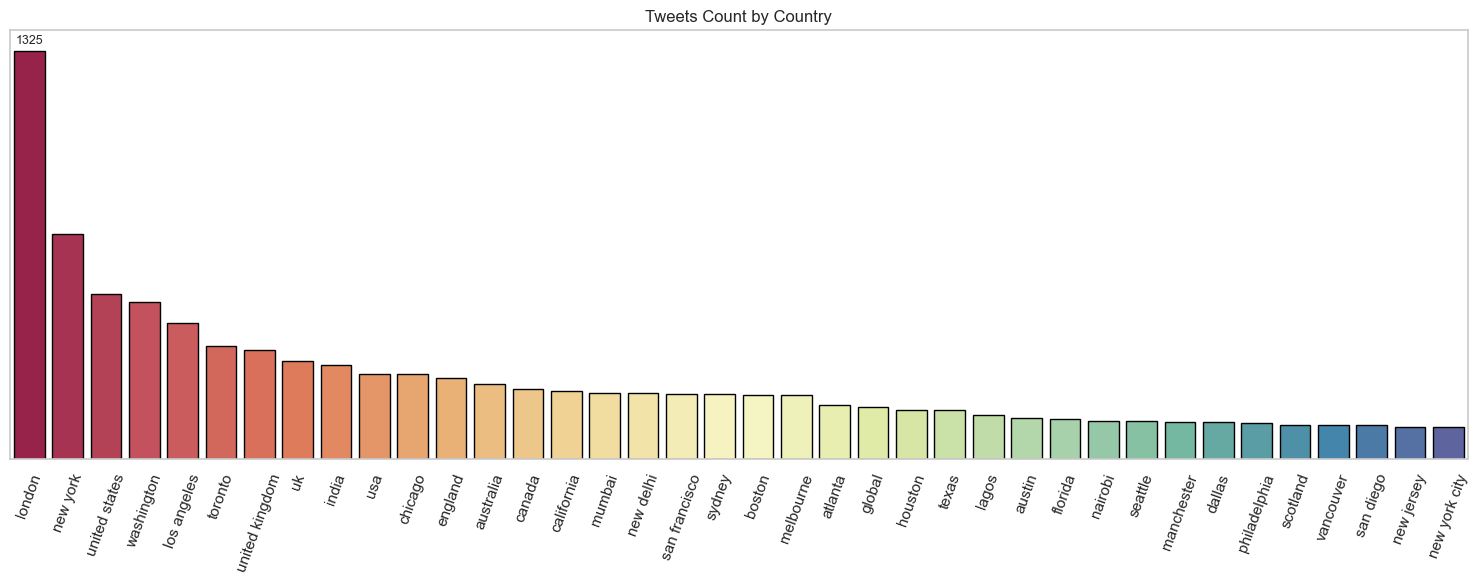

In [35]:
# Count tweets per country where count > 100
tweets_per_country = (
    train['CleanLocation']
    .value_counts()
    .loc[lambda x: x > 100]
    .reset_index()
)

# Rename columns correctly
tweets_per_country.columns = ['Country', 'Count']

# Plot
plt.figure(figsize=(15, 6))
ax = sns.barplot(
    x='Country', y='Count', data=tweets_per_country,
    edgecolor='black', ci=False, palette='Spectral'
)

plt.title('Tweets Count by Country')
plt.xticks(rotation=70)
plt.yticks([])
ax.bar_label(ax.containers[0], fontsize=9, padding=3)
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()


In [36]:
import re
import string
import pandas as pd
import html
from collections import Counter

# --------- Step 1: Extract Mentions and Hashtags ---------
train['Mentions'] = train['OriginalTweet'].apply(
    lambda x: re.findall(r'@\w+', x.lower()) if isinstance(x, str) else []
)

train['Hashtags'] = train['OriginalTweet'].apply(
    lambda x: re.findall(r'#\w+', x.lower()) if isinstance(x, str) else []
)

# --------- Step 2: Define Cleaning Functions ---------

# Clean emojis from text
def strip_emoji(text):
    return ''.join(char for char in text if not emoji.is_emoji(char))  # requires `emoji` library

# Remove mentions, non-ASCII chars, punctuation (preserve links)
def strip_all_entities(text):
    text = re.sub(r'[\r\n]+', ' ', text).lower()
    text = re.sub(r"\@\w+", "", text)  # remove mentions only
    text = re.sub(r'[^\x00-\x7f]', r'', text)  # remove non-ASCII chars
    banned_list = string.punctuation + 'Ã±ã¼â»§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Clean hashtags (remove trailing ones, strip # symbol from mid-text)
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split(
        '#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

# Replace '&' with 'and', remove words containing '$'
def filter_chars(text):
    sent = []
    for word in text.split(' '):
        if '$' in word:
            continue  # remove words with $
        elif '&' in word:
            sent.append(word.replace('&', 'and'))  # replace & with 'and'
        else:
            sent.append(word)
    return ' '.join(sent)

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r'\s\s+', ' ', text)

# --------- Step 3: Apply All Cleaning Steps ---------
train['fully_clean_text'] = train['OriginalTweet'].apply(strip_emoji)
train['fully_clean_text'] = train['fully_clean_text'].apply(html.unescape)  # decode &amp; etc.
train['fully_clean_text'] = train['fully_clean_text'].apply(strip_all_entities)
train['fully_clean_text'] = train['fully_clean_text'].apply(clean_hashtags)
train['fully_clean_text'] = train['fully_clean_text'].apply(filter_chars)
train['fully_clean_text'] = train['fully_clean_text'].apply(remove_mult_spaces)

# --------- Step 4: Preview & Explore ---------
print(train['fully_clean_text'].head())

# Most common hashtags and mentions
top_hashtags = Counter([tag for tags in train['Hashtags'] for tag in tags]).most_common(10)
top_mentions = Counter([m for mlist in train['Mentions'] for m in mlist]).most_common(10)

print("🔝 Top Hashtags:", top_hashtags)
print("🔝 Top Mentions:", top_mentions)


0                                  url and url and url
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
Name: fully_clean_text, dtype: object
🔝 Top Hashtags: [('#coronavirus', 15983), ('#covid19', 4837), ('#covid_19', 3163), ('#covid2019', 1673), ('#covid', 1631), ('#toiletpaper', 1614), ('#socialdistancing', 938), ('#coronacrisis', 767), ('#pandemic', 478), ('#stayhome', 453)]
🔝 Top Mentions: [('@realdonaldtrump', 254), ('@tesco', 199), ('@sainsburys', 161), ('@borisjohnson', 151), ('@amazon', 128), ('@narendramodi', 110), ('@asda', 109), ('@pmoindia', 96), ('@morrisons', 92), ('@piersmorgan', 85)]


C:\Users\rabea\AppData\Local\Temp\ipykernel_21712\1973186693.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=train[train['text_len'] < 10], palette='mako')


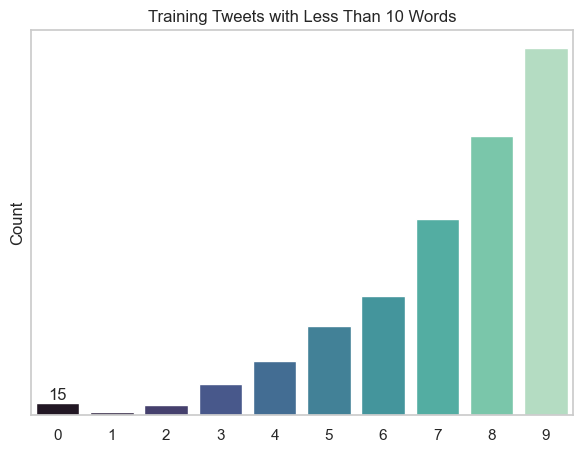

In [37]:
# Compute tweet length from fully_clean_text
train['text_len'] = train['fully_clean_text'].apply(lambda x: len(x.split()))

# Plot tweets with less than 10 words
plt.figure(figsize=(7, 5))
ax = sns.countplot(x='text_len', data=train[train['text_len'] < 10], palette='mako')
plt.title('Training Tweets with Less Than 10 Words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Count')
plt.xlabel('')
plt.show()


theres some words with very little amount of words or even ones that dont ahave any words, so we drop them

In [38]:
# Drop tweets with fewer than 5 words
train = train[train['text_len'] >= 4].reset_index(drop=True)
print(f"Remaining tweets: {len(train)}")


Remaining tweets: 41059


now we are gonna use the bert tokenizer to clean deeper

In [39]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
token_lens = []

for txt in train['fully_clean_text'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 100


In [40]:
token_lens = []

for i,txt in enumerate(train['fully_clean_text'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 1634, TEXT: zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme
INDEX: 13666, TEXT: hoy aplaudo a mi segunda familia aplaudoanuestrosheroes aquellos con los que he compartido tantas noches de trabajo y tanta alegra s que como siempre dan todo por el bien de su comunidad presidente por ellos tambin cuarentenanacionalya cuidemosalosquecuidan url
INDEX: 14564, TEXT: na wer war denn da am werk gestern nachmittag konnten anwohnerinnen des stadtteil praunheim in frankfurt diese aktion bestaunen wer dafr verantwortlich ist ist unklar danke an melanie theiss fr die zusendung des fotos bild elizabeth maks url
INDEX: 16599, TEXT: bir mddettir spermarketlerin lojistik hizmeti avusturya ordusu desteiyle yaplyor dn corona tedavisi iin 22 milyon luk bir aratrma gelitirme btesi aklad hkmet geen hafta da 35 mily

we can see that these sentences are either gibberish or in a different language. so we delete those

In [41]:
train['token_lens'] = token_lens

train = train.sort_values(by='token_lens', ascending=False)
train.head(20)

,Location,TweetAt,OriginalTweet,Sentiment,char_count,word_count,clean_text,HashtagCount,MentionCount,URLCount,QuestionMarkCount,LetterCount,MentionsList,has_@realdonaldtrump,has_@tesco,has_@sainsburys,has_@borisjohnson,has_@amazon,URLList,TweetDate,TweetWeekday,CleanLocation,Mentions,Hashtags,fully_clean_text,text_len,token_lens
1634,?eskÃ¡ republika,2020-03-17,zã¡sah policie proti spekulant?m s rouâkami. ...,Neutral,290,40,zsah policie proti spekulant?m s roukami. na m...,1,1,0,6,205,[@policiecz],False,False,False,False,False,[],2020-03-17,Tuesday,?eskã¡ republika,[@policiecz],[#spolutozvladneme],zsah policie proti spekulantm s roukami na mj ...,39,100
37066,?stanbul BÃ¼yÃ¼k?ehir Belediyesi,2020-04-10,11 nisan cumartesi itibariyle ?bbânin tã¼m hi...,Neutral,292,39,11 nisan cumartesi itibariyle ?bbnin tm hizmet...,0,0,0,9,209,[],False,False,False,False,False,[],2020-04-10,Friday,?stanbul bã¼yã¼k?ehir belediyesi,[],[],11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,98
16599,"Avusturya, Viyana",2020-03-22,bir mã¼ddettir sã¼permarketlerin lojistik hizm...,Neutral,311,37,bir mddettir spermarketlerin lojistik hizmeti ...,0,0,0,13,213,[],False,False,False,False,False,[https://t.co/vhv9xdugxh],2020-03-22,Sunday,avusturya,[],[],bir mddettir spermarketlerin lojistik hizmeti ...,37,94
13666,BogotÃ¡ D.C.,2020-03-21,hoy aplaudo a mi segunda familia #aplaudoanues...,Neutral,320,40,hoy aplaudo a mi segunda familia #aplaudoanues...,3,1,0,0,245,[@ivanduque],False,False,False,False,False,[https://t.co/edu8hbo5tz],2020-03-21,Saturday,bogotã¡ d.c.,[@ivanduque],"[#aplaudoanuestrosheroes, #cuarentenanacionaly...",hoy aplaudo a mi segunda familia aplaudoanuest...,39,86
14564,"Frankfurt am Main, Germany",2020-03-21,"na, wer war denn da am werk? gestern nachmitta...",Extremely Negative,278,38,"na, wer war denn da am werk? gestern nachmitta...",0,0,0,1,216,[],False,False,False,False,False,[https://t.co/ul10htio2h],2020-03-21,Saturday,frankfurt am main,[],[],na wer war denn da am werk gestern nachmittag ...,38,82
26948,Puerto Rico,2020-04-02,supermercados econo confirman que un empleado ...,Neutral,295,41,supermercados econo confirman que un empleado ...,1,0,0,1,231,[],False,False,False,False,False,[https://t.co/rvmhuyhaxz],2020-04-02,Thursday,puerto rico,[],[#coronaviruspr],supermercados econo confirman que un empleado ...,40,82
18871,"Ntare, Muti Lane Mbarara",2020-03-24,#croozefmnews \r\r\npresident museveni has ord...,Extremely Negative,309,41,#croozefmnews \r\r\npresident museveni has ord...,3,0,0,0,187,[],False,False,False,False,False,[https://t.co/41xnssfw9s],2020-03-24,Tuesday,ntare,[],"[#croozefmnews, #covid_19, #covid19ug]",croozefmnews president museveni has ordered th...,36,81
30140,"Lahore, Pakistan",2020-04-06,#lda city lahore residential files prices upda...,Neutral,319,44,#lda city lahore residential files prices upda...,4,0,0,0,201,[],False,False,False,False,False,[https://t.co/fvtdvsaseb],2020-04-06,Monday,lahore,[],"[#lda, #pandemic, #coronavirusinpakistan, #cov...",lda city lahore residential files prices updat...,44,80
28839,Nanning,2020-04-05,kindly contact us bamy global merchandise for ...,Positive,266,37,kindly contact us bamy global merchandise for ...,0,1,0,0,176,[@cosultant],False,False,False,False,False,[],2020-04-05,Sunday,nanning,[@cosultant],[],kindly contact us bamy global merchandise for ...,37,80
1693,Canada,2020-03-17,i work at a grocery store.\r\r\nwe wont get an...,Positive,302,38,i work at a grocery store.\r\r\nwe wont get an...,10,0,0,0,230,[],False,False,False,False,False,[https://t.co/djrwebyxmv],2020-03-17,Tuesday,canada,[],"[#fbp, #retweeet, #whyhasgodforsakenme, #tolie...",i work at a grocery store we wont get any toil...,38,79


we can see that the first 8, sentences are not normal english text, so we drop them

In [42]:
train = train.iloc[12:]
train.head(20)

,Location,TweetAt,OriginalTweet,Sentiment,char_count,word_count,clean_text,HashtagCount,MentionCount,URLCount,QuestionMarkCount,LetterCount,MentionsList,has_@realdonaldtrump,has_@tesco,has_@sainsburys,has_@borisjohnson,has_@amazon,URLList,TweetDate,TweetWeekday,CleanLocation,Mentions,Hashtags,fully_clean_text,text_len,token_lens
4837,London -UK,2020-03-18,impct of #coronavirus i hve sen hw civilizd pp...,Extremely Negative,279,48,impct of #coronavirus i hve sen hw civilizd pp...,3,0,0,0,217,[],False,False,False,False,False,[],2020-03-18,Wednesday,london -uk,[],"[#coronavirus, #uk, #uk]",impct of coronavirus i hve sen hw civilizd ppl...,48,79
12366,"Victoria, BC, Canada",2020-03-21,"okay, so i just checked the drug prices for #p...",Positive,310,38,"okay, so i just checked the drug prices for #p...",9,0,0,2,228,[],False,False,False,False,False,[https://t.co/ovypmnsmax],2020-03-21,Saturday,victoria,[],"[#plaquenil, #aralen, #chloroquine, #chloroqui...",okay so i just checked the drug prices for pla...,36,79
26622,"Berlin, Deutschland",2020-04-02,eine wahre #coronageschichte:\r\r\n\r\r\nwenn ...,Neutral,263,34,eine wahre #coronageschichte:\r\r\n\r\r\nwenn ...,3,0,0,4,189,[],False,False,False,False,False,[],2020-04-02,Thursday,berlin,[],"[#coronageschichte, #coronadiã, #feelthejr]",eine wahre coronageschichte wenn dir an der su...,29,78
14553,United Kingdom,2020-03-21,hiked prices in the face of the covid-19 crise...,Negative,296,52,hiked prices in the face of the covid-19 crise...,0,0,0,0,180,[],False,False,False,False,False,[],2020-03-21,Saturday,united kingdom,[],[],hiked prices in the face of the covid19 crises...,47,77
36217,NaN,2020-04-09,for sell sterile disposable anti bacterial wet...,Negative,303,33,for sell sterile disposable anti bacterial wet...,13,0,0,0,248,[],False,False,False,False,False,[https://t.co/jizbddszet],2020-04-09,Thursday,None,[],"[#disinfectant, #covid, #covid_19, #coronaviru...",for sell sterile disposable anti bacterial wet...,33,77
40234,NaN,2020-04-13,"grap some for your family and keep in safe, #h...",Positive,303,31,"grap some for your family and keep in safe, #h...",21,0,0,0,245,[],False,False,False,False,False,[https://t.co/gwqwfaxv7u],2020-04-13,Monday,None,[],"[#handsanitizer, #natural, #bathandbodyworks, ...",grap some for your family and keep in safe han...,31,77
34206,United States,2020-04-08,"$brzl scepter holdings, inc., developing hand ...",Positive,273,37,"$brzl scepter holdings, inc., developing hand ...",4,0,0,0,182,[],False,False,False,False,False,[https://t.co/hkymp3ad5g],2020-04-08,Wednesday,united states,[],"[#sanitizer, #hemp, #coronavirus, #covid19]",brzl scepter holdings inc developing hand sani...,37,76
9013,"Montevideo, Uruguay",2020-03-20,la escena se repite alrededor del mundo: desde...,Neutral,309,41,la escena se repite alrededor del mundo: desde...,1,1,0,1,238,[@issamahmed],False,False,False,False,False,"[https://t.co/atnmqpp7ph, https://t.co/gmb58hd...",2020-03-20,Friday,montevideo,[@issamahmed],[#afp],la escena se repite alrededor del mundo desde ...,40,76
36216,NaN,2020-04-09,sterile disposable anti bacterial wet wipes an...,Negative,279,31,sterile disposable anti bacterial wet wipes an...,14,0,0,0,230,[],False,False,False,False,False,[],2020-04-09,Thursday,None,[],"[#disinfectant, #covid, #covid_19, #coronaviru...",sterile disposable anti bacterial wet wipes an...,31,76
28918,WORLDWIDE,2020-04-05,pm of india mr. narendrea modi has taken very ...,Negative,307,34,pm of india mr. narendrea modi has taken very ...,15,0,0,0,231,[],False,False,False,False,False,[https://t.co/qhmojxa3ik],2020-04-05,Sunday,India,[],"[#narendramodi, #narendermodi, #coronavirus, #...",pm of india mr narendrea modi has taken very r...,34,75


we noticed that the \r\r\n wasnt deleted correctly so we created a new function

In [43]:
def clean_line_breaks(text):
    # Replace sequences like \r, \n, \r\n, \r\r\n with a space
    text = re.sub(r'[\r\n]+', ' ', text)
    # Collapse multiple spaces and strip leading/trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text
train['fully_clean_text'] = train['fully_clean_text'].apply(clean_line_breaks)
train['fully_clean_text'].head(20)

4837     impct of coronavirus i hve sen hw civilizd ppl...
12366    okay so i just checked the drug prices for pla...
26622    eine wahre coronageschichte wenn dir an der su...
14553    hiked prices in the face of the covid19 crises...
36217    for sell sterile disposable anti bacterial wet...
40234    grap some for your family and keep in safe han...
34206    brzl scepter holdings inc developing hand sani...
9013     la escena se repite alrededor del mundo desde ...
36216    sterile disposable anti bacterial wet wipes an...
28918    pm of india mr narendrea modi has taken very r...
22967    4 arrested in koboko northern uganda for hikin...
28875    hey guys thanks to the covid 19 quarantine the...
34784    when youre out of toilet paper and need to buy...
36456    global tenders rfp for disinfectant sanitizer ...
8261     francisco shared this photo with us from santa...
14726    ciudadano brasileo muestra su sorpresa positiv...
29472    achat local le url encourage les qubcois faire.

we can see "amp" staying when removing the '&' symbol and we fix it

In [44]:
import html

# Decode entities like &amp; → &
train['fully_clean_text'] = train['fully_clean_text'].apply(html.unescape)
train['fully_clean_text'].head(20)


4837     impct of coronavirus i hve sen hw civilizd ppl...
12366    okay so i just checked the drug prices for pla...
26622    eine wahre coronageschichte wenn dir an der su...
14553    hiked prices in the face of the covid19 crises...
36217    for sell sterile disposable anti bacterial wet...
40234    grap some for your family and keep in safe han...
34206    brzl scepter holdings inc developing hand sani...
9013     la escena se repite alrededor del mundo desde ...
36216    sterile disposable anti bacterial wet wipes an...
28918    pm of india mr narendrea modi has taken very r...
22967    4 arrested in koboko northern uganda for hikin...
28875    hey guys thanks to the covid 19 quarantine the...
34784    when youre out of toilet paper and need to buy...
36456    global tenders rfp for disinfectant sanitizer ...
8261     francisco shared this photo with us from santa...
14726    ciudadano brasileo muestra su sorpresa positiv...
29472    achat local le url encourage les qubcois faire.

In [45]:
train.to_csv("modified_train.csv", index=False)